In [1]:
# load libraies

%run py_libraries.py

/Users/4476224/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# loading utility files

from utility.sv_fig import savefig
from utility.make_cm import make_confusion_matrix
from utility.get_g_result import get_gamma_results
from utility.plt_result import plot_results

In [3]:
def savefig(filename, crop = True):
    plt.savefig('{}.pdf'.format(filename))

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# load data
# X_train = pd.read_csv('data/norm_X_train_NCa_Ca.csv')
# y_train = pd.read_csv('data/y_train_NCa_Ca.csv')

data = pd.read_csv('data/Xy_PCa_Ca_md.csv')

print(data.shape)

(109, 38)


In [5]:
# MI

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import StratifiedKFold, KFold

# ---- Data ----
X = data.drop(columns=['CACHEXSTAGE0VIG'])
y = data['CACHEXSTAGE0VIG']

# Detect task type
is_classification = y.nunique() < 20 and not np.issubdtype(y.dtype, np.floating)

# Fill missing values (consistent across folds)
X_filled = X.fillna(0)

# ---- Cross-validation setup ----
n_splits = 5

if is_classification:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
else:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mi_scores = []

# ---- CV loop ----
for fold, (train_idx, _) in enumerate(cv.split(X_filled, y)):
    X_train = X_filled.iloc[train_idx]
    y_train = y.iloc[train_idx]

    if is_classification:
        mi = mutual_info_classif(
            X_train,
            y_train,
            discrete_features='auto',
            random_state=42
        )
    else:
        mi = mutual_info_regression(
            X_train,
            y_train,
            random_state=42
        )

    mi_scores.append(mi)

# ---- Aggregate MI ----
mi_scores = np.vstack(mi_scores)

mi_df = pd.DataFrame(
    {
        "MI_mean": mi_scores.mean(axis=0),
        "MI_std": mi_scores.std(axis=0),
    },
    index=X.columns
).sort_values("MI_mean", ascending=False)

print("\n=== Cross-Validated Mutual Information Feature Ranking ===")
print(mi_df.round(10))



=== Cross-Validated Mutual Information Feature Ranking ===
               MI_mean    MI_std
ENA.78        0.070736  0.063303
HIF.1a        0.061599  0.018395
IL.10         0.059896  0.026627
MIP.3a        0.046191  0.027687
MIP.1a        0.043229  0.024255
Glucose       0.041398  0.018709
PPAR.y        0.038460  0.034643
TNF.a         0.032772  0.034718
GDF.15        0.031867  0.033152
HbA1c         0.025219  0.024046
TIMP.1        0.024504  0.029323
Leptin        0.021759  0.017841
Adiponectin   0.020813  0.019381
MCP.1         0.020331  0.015521
ZAG           0.015543  0.025562
Insulin       0.015423  0.015777
LDL           0.014559  0.018926
MMP.2         0.013158  0.011318
CRP           0.010572  0.013119
G.CSF         0.009539  0.017603
IFN.y         0.009414  0.018827
TGF.B2        0.009198  0.012379
IL.8          0.007298  0.009395
Albumin       0.006257  0.012514
C.peptide     0.006149  0.012299
IL.6          0.005756  0.011511
CA19.9        0.005694  0.007010
MDC           0.

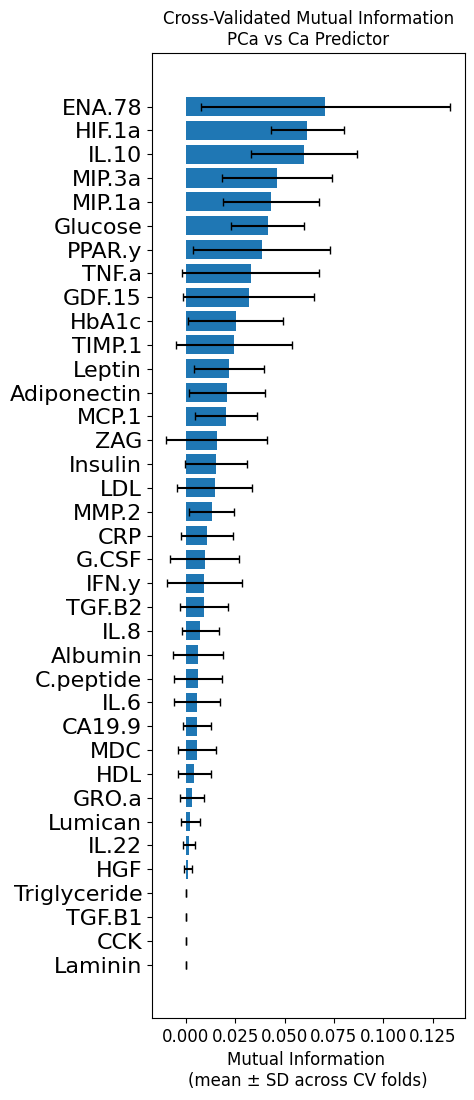

In [7]:
import matplotlib.pyplot as plt

# ---- Plot CV Mutual Information (mean ± std) ----
mi_plot = mi_df.sort_values("MI_mean")

plt.figure(figsize=(5, max(4, 0.3 * len(mi_plot))))

plt.barh(
    mi_plot.index,
    mi_plot["MI_mean"],
    xerr=mi_plot["MI_std"],
    capsize=3
)

plt.yticks(fontsize=16)
plt.xticks(fontsize=12) 

plt.xlabel("Mutual Information \n(mean ± SD across CV folds)", fontsize=12)
plt.title("Cross-Validated Mutual Information\nPCa vs Ca Predictor", fontsize=12)
plt.tight_layout()

plt.savefig("./figs/PCa_Ca_MI", dpi=300)
# plt.show()
